In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import ipywidgets as widgets
from IPython.display import display
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster


In [2]:
import pandas as pd

# Load the dataset from the Final Datasets folder
file_path = 'Final Datasets/N1_Cleaned_fueldata.csv'
data = pd.read_csv(file_path)

# Display the first few rows and summary information
data_info = data.info()
data_head = data.head()

data_info, data_head


# Putting data into another variable
data_cleaned = data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972174 entries, 0 to 972173
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PUBLISH_DATE         972174 non-null  object 
 1   TRADING_NAME         972174 non-null  object 
 2   BRAND_DESCRIPTION    972174 non-null  object 
 3   PRODUCT_DESCRIPTION  972174 non-null  object 
 4   PRODUCT_PRICE        972174 non-null  float64
 5   ADDRESS              972174 non-null  object 
 6   LOCATION             972174 non-null  object 
 7   POSTCODE             972174 non-null  int64  
 8   AREA_DESCRIPTION     972174 non-null  object 
 9   REGION_DESCRIPTION   972174 non-null  object 
 10  latitude             972174 non-null  float64
 11  longitude            972174 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 89.0+ MB


# Brand Clustering
## 	Hypothesis : Same brand in one area will charge higher prices : Rejected

In [3]:
# Group by brand (TRADING_NAME) and calculate the average price for each brand
brand_prices = data_cleaned.groupby('BRAND_DESCRIPTION')['PRODUCT_PRICE'].mean().reset_index()

# Sort by price to see which brands charge more
brand_prices_sorted = brand_prices.sort_values(by='PRODUCT_PRICE', ascending=False)
print(brand_prices_sorted)


    BRAND_DESCRIPTION  PRODUCT_PRICE
22      reddy express     187.753281
2              astron     186.330014
11           eg ampol     184.283618
1               ampol     180.416766
19                otr     177.833123
20        petro fuels     177.180867
17    metro petroleum     173.377286
6                burk     173.291162
27      x convenience     173.071498
3               atlas     170.854730
0            7-eleven     164.486906
5                  bp     163.892764
9       coles express     162.656757
14        independent     162.568179
16            liberty     160.912344
25               vibe     160.901557
24             united     157.840269
23              shell     155.207811
7              caltex     155.138659
4       better choice     154.101085
21               puma     150.908545
10             costco     150.847373
12      fastfuel 24/7     148.711758
8   caltex woolworths     144.549435
26              wesco     140.620384
18              mogas     131.422523
1

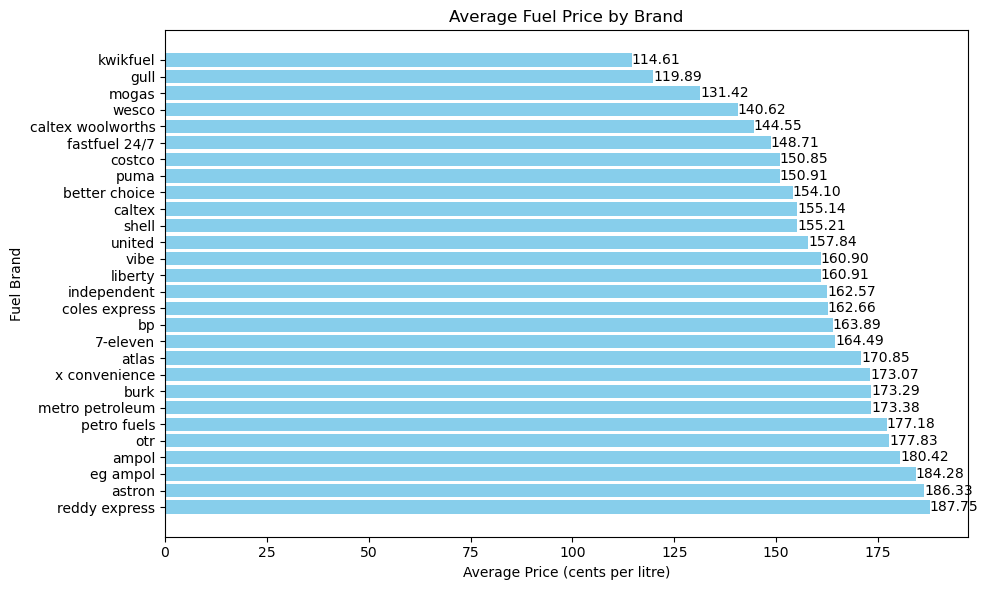

In [4]:
plt.figure(figsize=(10, 6))
bars = plt.barh(brand_prices_sorted['BRAND_DESCRIPTION'], brand_prices_sorted['PRODUCT_PRICE'], color='skyblue')

plt.xlabel('Average Price (cents per litre)')
plt.ylabel('Fuel Brand')
plt.title('Average Fuel Price by Brand')

# Adding labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}',  # Format the price to 2 decimal places
             va='center')  # Vertical alignment

plt.tight_layout()
plt.show()



# Interactive Map to find Brand Clusters


In [5]:
# Convert the 'PUBLISH_DATE' column to datetime 
data_cleaned['PUBLISH_DATE'] = pd.to_datetime(data_cleaned['PUBLISH_DATE'])

# Set 'PUBLISH_DATE' as the index for time-based analysis
data_cleaned.set_index('PUBLISH_DATE', inplace=True)

# Add a column for 'YEAR' extracted from 'PUBLISH_DATE'
data_cleaned['YEAR'] = data_cleaned.index.year

# Filter data based on the 'AREA_DESCRIPTION' column to divide into North, South, and East/Hills
north_data = data_cleaned[data_cleaned['AREA_DESCRIPTION'] == 'North of River']
south_data = data_cleaned[data_cleaned['AREA_DESCRIPTION'] == 'South of River']
east_data = data_cleaned[data_cleaned['AREA_DESCRIPTION'] == 'East/Hills']

# Group data by 'latitude', 'longitude' to calculate the average price per station for each region
north_location_prices = north_data.groupby(['latitude', 'longitude', 'BRAND_DESCRIPTION', 'YEAR'])['PRODUCT_PRICE'].mean().reset_index()
south_location_prices = south_data.groupby(['latitude', 'longitude', 'BRAND_DESCRIPTION', 'YEAR'])['PRODUCT_PRICE'].mean().reset_index()
east_location_prices = east_data.groupby(['latitude', 'longitude', 'BRAND_DESCRIPTION', 'YEAR'])['PRODUCT_PRICE'].mean().reset_index()

# To Get the unique list of years and brands for the dropdown options
years = sorted(data_cleaned['YEAR'].unique())
brands = sorted(data_cleaned['BRAND_DESCRIPTION'].unique())

# Function to generate the cluster map for a selected region, brand, and years
def generate_cluster_map(region, selected_brand=None, selected_years=None):
    if region == 'North of River':
        location_prices = north_location_prices
    elif region == 'South of River':
        location_prices = south_location_prices
    else:
        location_prices = east_location_prices

    # If a brand is selected, filter the data by that brand
    if selected_brand and selected_brand != 'All':
        location_prices = location_prices[location_prices['BRAND_DESCRIPTION'] == selected_brand]

    # If specific years are selected and "All" is not chosen, filter the data by those years
    if selected_years and 'All' not in selected_years:
        location_prices = location_prices[location_prices['YEAR'].isin(selected_years)]

    # Calculate the average price for each brand in the region
    brand_avg_price = location_prices.groupby('BRAND_DESCRIPTION')['PRODUCT_PRICE'].mean().reset_index()

    # Merge the average brand price with the location prices
    data_with_avg = pd.merge(location_prices, brand_avg_price, on='BRAND_DESCRIPTION', suffixes=('', '_brand_avg'))

    # Create a map centered on Perth
    region_map = folium.Map(location=[-31.9505, 115.8605], zoom_start=10)

    # Create a MarkerCluster to optimize the map
    marker_cluster = MarkerCluster().add_to(region_map)

    # Define some colors for different brands (you can add more if needed)
    brand_colors = {
        'Shell': 'red',
        'BP': 'green',
        'Ampol': 'blue',
        'Caltex': 'orange',
        '7-Eleven': 'purple',
        'Gull': 'pink',
        'Liberty': 'lightblue',
        'Independent': 'darkgreen',
        # Add other brands as needed
    }

    # Add markers to the cluster, colored by brand and whether the station charges more than the average price for that brand
    for index, row in data_with_avg.iterrows():
        brand = row['BRAND_DESCRIPTION']
        # Use a default color if the brand is not in the defined colors
        color = brand_colors.get(brand, 'gray')

        # Add each marker to the marker cluster
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{row['BRAND_DESCRIPTION']} - {row['PRODUCT_PRICE']} cents in {row['YEAR']}",
            icon=folium.Icon(color='red' if row['PRODUCT_PRICE'] > row['PRODUCT_PRICE_brand_avg'] else 'green')
        ).add_to(marker_cluster)

    region_safe = region.replace('/', '_')

    # Save the map to an HTML file
    region_map.save(f'{region_safe}_station_cluster_map.html')
    
    return region_map

# Create dropdown widget for region selection
region_dropdown = widgets.Dropdown(
    options=['North of River', 'South of River', 'East/Hills'],
    value='North of River',
    description='Select Region:',
    disabled=False,
)

# Create dropdown widget for brand selection
brand_dropdown = widgets.Dropdown(
    options=['All'] + brands,  # 'All' option to show all brands
    value='All',
    description='Select Brand:',
    disabled=False,
)

# Create multi-select widget for year selection (with "All Years" option)
year_selection = widgets.SelectMultiple(
    options=['All'] + years,  # 'All' option added to allow viewing all years combined
    value=['All'],  # By default, select "All Years"
    description='Select Years:',
    disabled=False
)

# Display the dropdowns
display(region_dropdown, brand_dropdown, year_selection)

# Display the map for the selected region, brand, and years
output = widgets.Output()

# Define the callback function to update the map based on dropdown selections and years
def update_cluster_map(change):
    with output:
        output.clear_output()  # Clear previous map
        region_map = generate_cluster_map(
            region=region_dropdown.value, 
            selected_brand=brand_dropdown.value, 
            selected_years=list(year_selection.value)
        )
        display(region_map)

# Attach the callback to the dropdowns and year selection
region_dropdown.observe(update_cluster_map, names='value')
brand_dropdown.observe(update_cluster_map, names='value')
year_selection.observe(update_cluster_map, names='value')

# Display the initial map
with output:
    display(generate_cluster_map('North of River', 'All', ['All']))

display(output)


Dropdown(description='Select Region:', options=('North of River', 'South of River', 'East/Hills'), value='Nort…

Dropdown(description='Select Brand:', options=('All', '7-eleven', 'ampol', 'astron', 'atlas', 'better choice',…

SelectMultiple(description='Select Years:', index=(0,), options=('All', 2020, 2021, 2022, 2023, 2024), value=(…

Output()

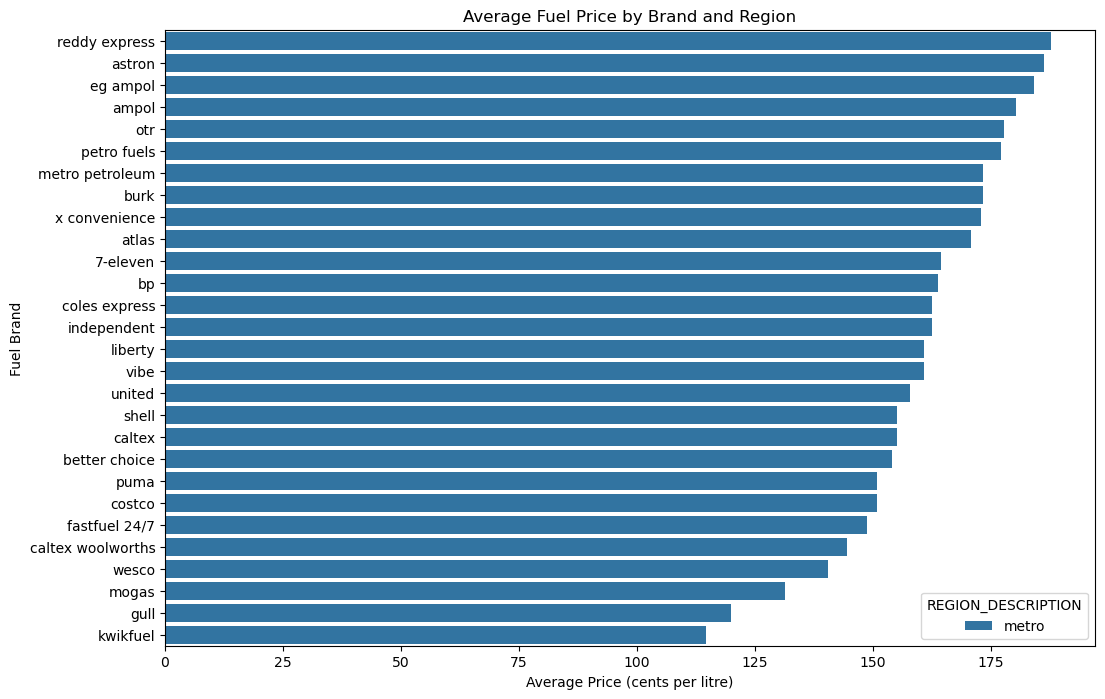

In [6]:
# Grouping by Region and Brand, and calculating the average price
region_brand_prices = data_cleaned.groupby(['REGION_DESCRIPTION', 'BRAND_DESCRIPTION'])['PRODUCT_PRICE'].mean().reset_index()

# Sorting by region to see price patterns
region_brand_prices_sorted = region_brand_prices.sort_values(by='PRODUCT_PRICE', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(data=region_brand_prices_sorted, x='PRODUCT_PRICE', y='BRAND_DESCRIPTION', hue='REGION_DESCRIPTION')
plt.xlabel('Average Price (cents per litre)')
plt.ylabel('Fuel Brand')
plt.title('Average Fuel Price by Brand and Region')
plt.show()

In [7]:
price_variance = data_cleaned.groupby('REGION_DESCRIPTION')['PRODUCT_PRICE'].var()
print(price_variance)


REGION_DESCRIPTION
metro    981.217983
Name: PRODUCT_PRICE, dtype: float64


In [8]:
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare the data for clustering (latitude, longitude, and price)
X = data_cleaned[['latitude', 'longitude', 'PRODUCT_PRICE']].values

# Perform DBSCAN clustering
db = DBSCAN(eps=0.05, min_samples=50).fit(X)

# Assign the cluster labels back to the dataframe
data_cleaned['cluster'] = db.labels_

# Check if certain clusters have higher prices
clustered_data = data_cleaned.groupby('cluster')['PRODUCT_PRICE'].mean()
print(clustered_data)


cluster
-1       153.697302
 0       156.500000
 1       153.900000
 2       157.500000
 3       157.500000
            ...    
 1434    214.900000
 1435    173.300000
 1436    200.900000
 1437    182.900000
 1438    170.300000
Name: PRODUCT_PRICE, Length: 1440, dtype: float64


# Boxplot of Fuel Price Distribution by Brand

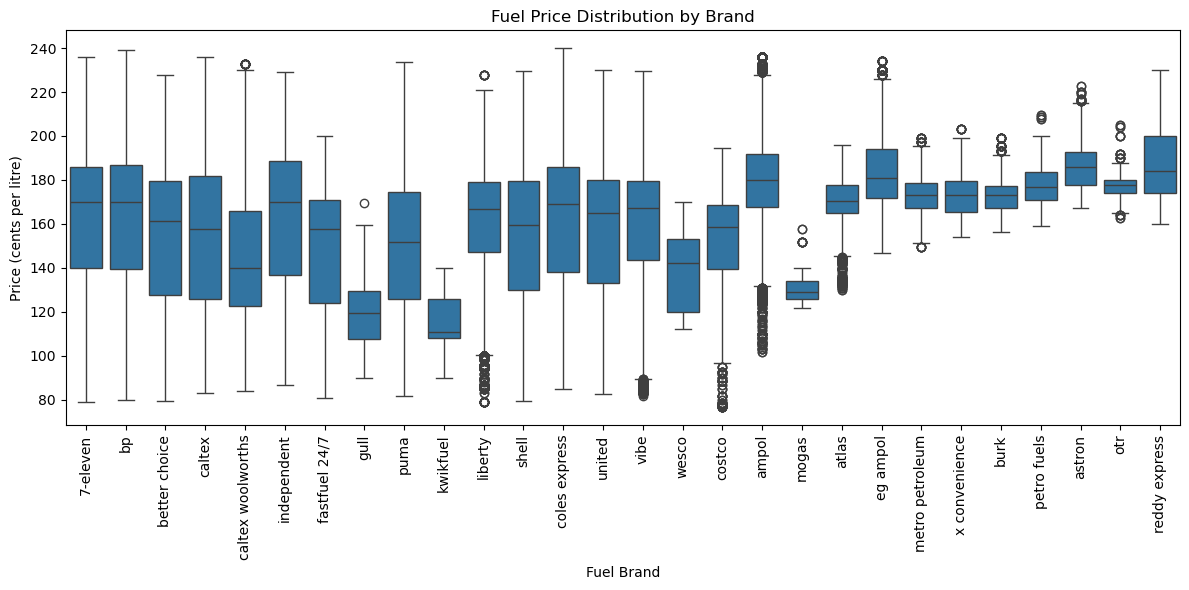

In [9]:
# Plot a boxplot to show the distribution of prices by Brand across all regions
plt.figure(figsize=(12, 6))
sns.boxplot(x='BRAND_DESCRIPTION', y='PRODUCT_PRICE', data=data_cleaned)
plt.xticks(rotation=90)
plt.xlabel('Fuel Brand')
plt.ylabel('Price (cents per litre)')
plt.title('Fuel Price Distribution by Brand')
plt.tight_layout()
plt.show()

# Cluster Creation using DBSCAN

In [10]:

#  Sample the data (taking 10% of the original data)
data_sampled = data_cleaned.sample(frac=0.1, random_state=42)

#  Prepare the data for clustering (using latitude and longitude)
X_sample = data_sampled[['latitude', 'longitude']].values

# Step 3: Perform DBSCAN clustering with parameter tuning
try:
    # Adjusted DBSCAN parameters (increase eps to form more clusters)
    db = DBSCAN(eps=0.5, min_samples=100).fit(X_sample)
    
    # Assign the cluster labels back to the sampled dataframe
    data_sampled['cluster'] = db.labels_
    
    # Group by cluster and calculate the average price for each cluster
    clustered_data = data_sampled.groupby('cluster')['PRODUCT_PRICE'].mean().reset_index()
    print("DBSCAN Clustering Result:")
    print(clustered_data)
    
    # Step 4: Plot the boxplot with DBSCAN clusters
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster', y='PRODUCT_PRICE', data=data_sampled)
    plt.xticks(rotation=90)
    plt.xlabel('Cluster')
    plt.ylabel('Average Fuel Price (cents per litre)')
    plt.title('Fuel Price Distribution by Cluster (DBSCAN)')
    plt.tight_layout()
    plt.show()

except MemoryError:
    print("MemoryError: DBSCAN ran out of memory. Trying MiniBatchKMeans instead...")

    # Step 5: Perform MiniBatchKMeans clustering as an alternative
    kmeans = MiniBatchKMeans(n_clusters=50, batch_size=1000, random_state=42)
    data_sampled['cluster'] = kmeans.fit_predict(X_sample)
    
    # Group by cluster and calculate the average price for each cluster
    clustered_data = data_sampled.groupby('cluster')['PRODUCT_PRICE'].mean().reset_index()
    print("MiniBatchKMeans Clustering Result:")
    print(clustered_data)
    
    # Step 6: Plot the boxplot with MiniBatchKMeans clusters
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster', y='PRODUCT_PRICE', data=data_sampled)
    plt.xticks(rotation=90)
    plt.xlabel('Cluster')
    plt.ylabel('Average Fuel Price (cents per litre)')
    plt.title('Fuel Price Distribution by Cluster (MiniBatchKMeans)')
    plt.tight_layout()
    plt.show()


MemoryError: DBSCAN ran out of memory. Trying MiniBatchKMeans instead...


NameError: name 'MiniBatchKMeans' is not defined

In [11]:
# Calculate the variance for each cluster
cluster_variance = data_sampled.groupby('cluster')['PRODUCT_PRICE'].var()
print(cluster_variance)


cluster
-1       1448.049335
 0          0.000000
 1          0.000000
 2          0.000000
 3          0.000000
            ...     
 1434       0.000000
 1435       0.000000
 1436            NaN
 1437       0.000000
 1438       0.000000
Name: PRODUCT_PRICE, Length: 1438, dtype: float64


In [14]:
# Calculate the average price for each brand across all clusters
brand_avg_prices = data_sampled.groupby('BRAND_DESCRIPTION')['PRODUCT_PRICE'].mean().reset_index()
brand_avg_prices.columns = ['BRAND_DESCRIPTION', 'overall_avg_price']

# Calculate the average price for each brand within each cluster
cluster_brand_prices = data_sampled.groupby(['cluster', 'BRAND_DESCRIPTION'])['PRODUCT_PRICE'].mean().reset_index()
cluster_brand_prices.columns = ['cluster', 'BRAND_DESCRIPTION', 'cluster_avg_price']

# Merge the overall brand averages with the cluster-specific averages
merged_prices = pd.merge(cluster_brand_prices, brand_avg_prices, on='BRAND_DESCRIPTION')

# Calculate the price difference (cluster avg price - overall avg price)
merged_prices['price_diff'] = merged_prices['cluster_avg_price'] - merged_prices['overall_avg_price']

# Identify clusters where a brand's price is higher than its overall average
high_price_clusters = merged_prices[merged_prices['price_diff'] > 0]

# Sort the results to find clusters with the largest price differences
high_price_clusters_sorted = high_price_clusters.sort_values(by='price_diff', ascending=False)

# Display clusters where brands are charging significantly higher prices
print(high_price_clusters_sorted)




      cluster  BRAND_DESCRIPTION  cluster_avg_price  overall_avg_price  \
5450     1286  caltex woolworths              229.9         144.274073   
5441     1284  caltex woolworths              229.9         144.274073   
5592     1342  caltex woolworths              225.9         144.274073   
5190     1211  caltex woolworths              221.9         144.274073   
5181     1210  caltex woolworths              221.9         144.274073   
...       ...                ...                ...                ...   
5775     1431                 bp              163.9         163.761520   
1238      217                 bp              163.9         163.761520   
996       165                 bp              163.9         163.761520   
3628      832                 bp              163.9         163.761520   
1024      168        independent              163.7         163.586324   

      price_diff  
5450   85.625927  
5441   85.625927  
5592   81.625927  
5190   77.625927  
5181   77.625927

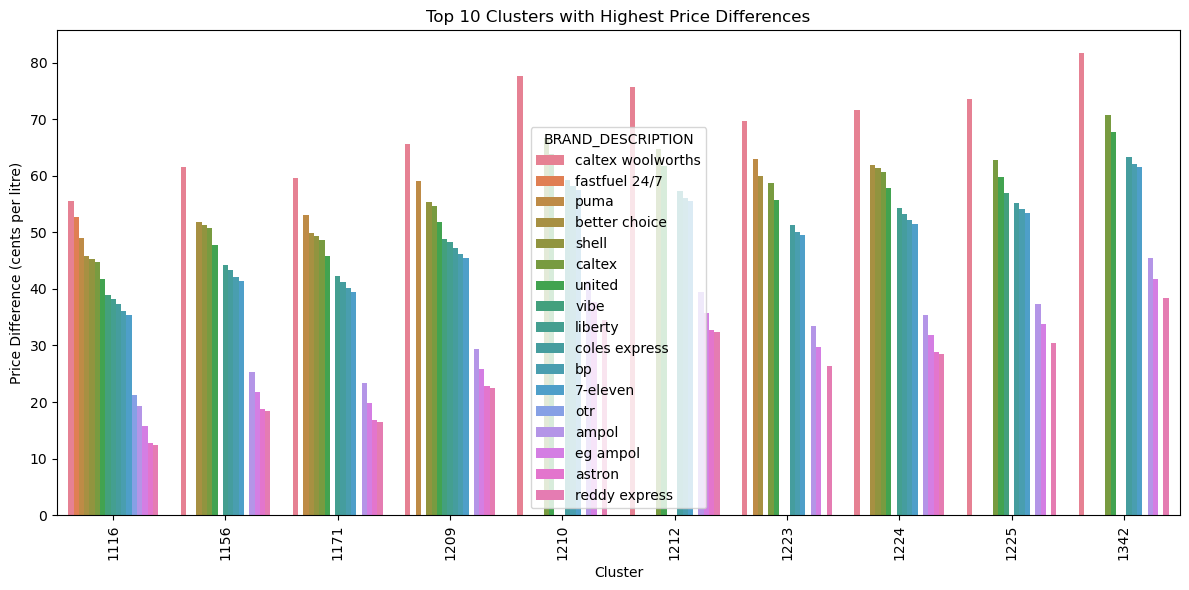

In [15]:
# Select top 10 clusters with the highest price differences
top_clusters = high_price_clusters_sorted.groupby('cluster')['price_diff'].sum().nlargest(10).index
top_clusters_data = high_price_clusters_sorted[high_price_clusters_sorted['cluster'].isin(top_clusters)]

# Plot only the top 10 clusters
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='price_diff', hue='BRAND_DESCRIPTION', data=top_clusters_data)
plt.xlabel('Cluster')
plt.ylabel('Price Difference (cents per litre)')
plt.title('Top 10 Clusters with Highest Price Differences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Used a method called KMeans Clustering, which is a way of grouping data points based on their latitude and longitude. Each "cluster" represents a group of fuel stations that are geographically close to each other.
In this analysis, we divided the data into 50 clusters. Each cluster represents a different area or neighborhood where multiple fuel stations are located.

ach cluster represents a local area where we group fuel stations based on their location. In each cluster, we compare the fuel prices charged by different brands to see if any of them are charging significantly higher than usual. For example, in Cluster 1, Caltex is charging 25 cents more per litre than its average price across other areas. This helps us identify where certain brands are raising prices and possibly taking advantage of their position in the market

Caltex Dominance:

Cluster 1, 6, 13, and 38 show Caltex with the highest price differences. In these clusters, Caltex appears to be charging prices that are significantly higher than its overall brand average. These might be clusters where Caltex is the dominant brand or has less competition.
In some clusters like 1 and 38, Caltex's price difference is well above 20 cents per litre, indicating that they might be exploiting a local advantage (perhaps due to lack of competition or being in a high-demand area).
BP Charging Higher in Several Clusters:

Cluster 3, 6, and 13 show BP with high price differences as well, particularly in cluster 6 where BP's price difference is around 20 cents. This suggests BP might be clustering in certain areas where it's able to charge higher-than-average prices.

Potential Hypotheses Based on the Plot:
Caltex seems to charge higher prices across multiple clusters, suggesting it either has a competitive edge in certain areas or operates in high-demand regions.

Reddy Express in cluster 44 and BP in cluster 6 both show considerable price increases, which could imply a lack of competition in these clusters.

Cluster 44 might be worth investigating further, as both Shell and Reddy Express are significantly above their average, indicating that this cluster may have limited pricing competition or unique regional conditions.